In [1]:
%load_ext autoreload
%autoreload 2
from src.data.make_dataset import make_cat_dict,calc_reactor_metrics

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [5]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")

# 1) Unary dataset

In [8]:
#load in reactor data
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
fname = "3-averaged_Round1-Standardized.csv"
df = pd.read_csv(processed_dir+"/"+fname,index_col=0)
df.head()

,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,lifetime_yield_sd,Y_pc_sd,sqrtY0Y_pc_sd
0,1,0,0,0,0,0,0,0,0.009888,0.079167,7.906378,7.122892,0.749430,1.391523,0.117528,0.012366
1,1,0,0,0,0,1,0,0,0.006639,0.052747,7.944507,6.330042,0.577835,1.398233,0.104446,0.009534
2,1,0,0,0,0,4,0,0,0.005610,0.211910,37.771519,27.945063,2.433485,6.647787,0.461094,0.040152
3,1,0,0,0,0,8,0,0,0.006555,0.162041,24.720653,19.593907,1.781855,4.350835,0.323299,0.029401
4,1,0,0,0,1,0,0,0,0.006305,0.211454,33.538397,26.152810,2.351620,5.902758,0.431521,0.038802


Next we generate plots for each bimetallic.

In [10]:
def get_bimetallics_of_x(df,x,metals=['Sn','Ga','Fe','Cu','Ca']):
    #returns subset of df that contains only metal x and Pt, no trimetallics or more
    df_ret = df
    for metal in metals:
        if metal != x:
            df_ret = df_ret[df_ret[metal] == 0]
    return df_ret

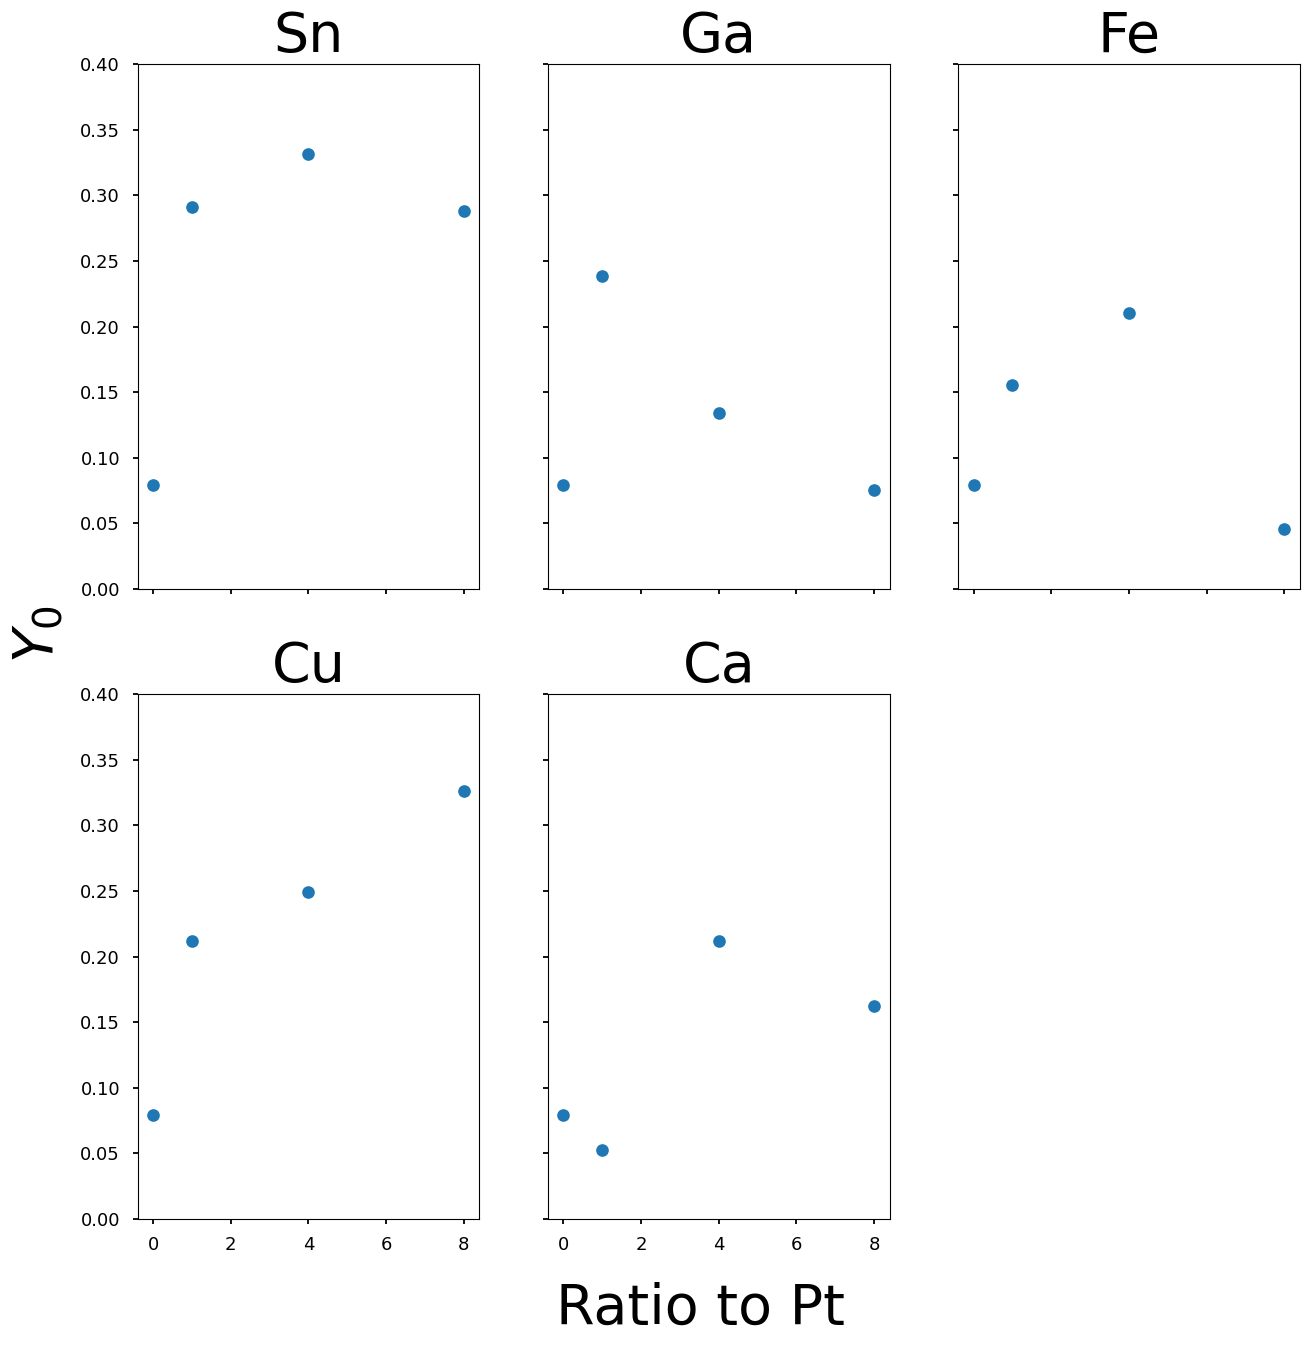

In [46]:
metric = 'Y0'
metals = ['Sn','Ga','Fe','Cu','Ca']
# df['diversity'] = df[metals].astype(bool).sum(axis=1) + 1.0
# df['loading'] = df[metals].sum(axis=1) + 1.0
# features = metals
# features.append('loading')
# print(df.head())
nrows = 2
ncols = 3
increment = 0
fig, axs = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        try:
            metal = metals[increment]
            if metal == "loading" or metal =="diversity":
                df_subset = df.copy()
            else:
                df_subset = get_bimetallics_of_x(df,metal)
            axs[i,j].plot(df_subset[metal],df_subset[metric],'o',label=metal)
            axs[i,j].set_title(metal,fontsize=40)
            axs[i,j].set_ylim([0, 0.4])
        except IndexError:
            a=2
        increment += 1
#Source: https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
fig.text(0.5, 0.04, 'Ratio to Pt',fontsize=40, ha='center')
fig.text(0.04, 0.5,'$Y_0$',fontsize=40, va='center', rotation='vertical')
#'$\sqrt{Y_0Y_{PC}}$'
# plt.xlabel('Ratio to Pt',fontsize=40)
# plt.ylabel('$\sqrt{Y_0Y_{PC}}$',fontsize=40)

# plt.legend(loc='best')
fig.delaxes(axs[1,2])  # https://stackoverflow.com/questions/28738836/how-to-create-an-odd-number-of-subplots
#fig.tight_layout()
plt.savefig('./manuscript_figures/training-data-feature-plots-y0.png',dpi=600,bbox_inches="tight")
    


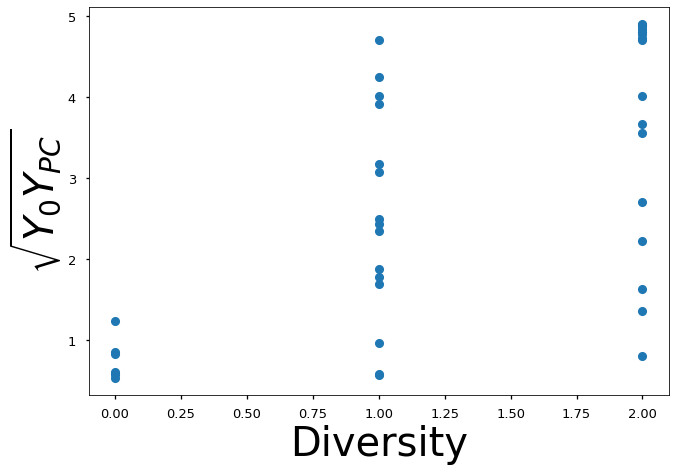

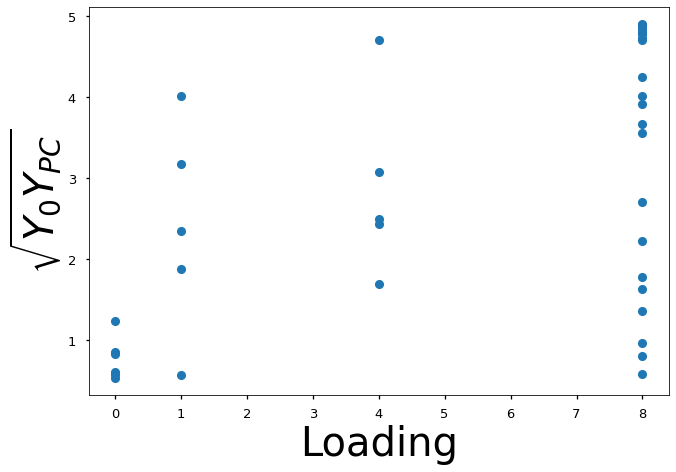

In [31]:
metals = ['Sn','Ga','Fe','Cu','Ca']
metric = 'sqrtY0Y_pc'

df["diversity"] =df[metals].astype(bool).sum(axis=1) #counts non-zero in a given row https://stackoverflow.com/questions/26053849/counting-non-zero-values-in-each-column-of-a-dataframe-in-python
plt.plot(df["diversity"],df[metric],'o',label=metal)
plt.ylabel("$\sqrt{Y_0Y_{PC}}$",fontsize=40)
plt.xlabel("Diversity",fontsize=40)
#plt.savefig('./figures/diversity-vs-sqrtyoypc.png',dpi=300,bbox_inches="tight")
plt.show()

df["loading"] =df[metals].sum(axis=1)
plt.plot(df["loading"],df[metric],'o',label=metal)
plt.ylabel("$\sqrt{Y_0Y_{PC}}$",fontsize=40)
plt.xlabel("Loading",fontsize=40)
#plt.savefig('./figures/loading-vs-sqrtyoypc.png',dpi=300,bbox_inches="tight")
plt.show()

# 2) Binary dataset

In [58]:
def get_trimetallics_of_x(df,x,metals=['Sn','Ga','Fe','Cu','Ca']):
    #returns subset of df that contains only metal x in a trimetallic
    df_ret = df[df[x] != 0].copy() # must contain x
    df_ret['is_trimetallic']=df_ret[metals].astype(bool).sum(axis=1)
    df_ret = df_ret[df_ret['is_trimetallic']==2.0].copy() #2 non-Pt metals
    return df_ret


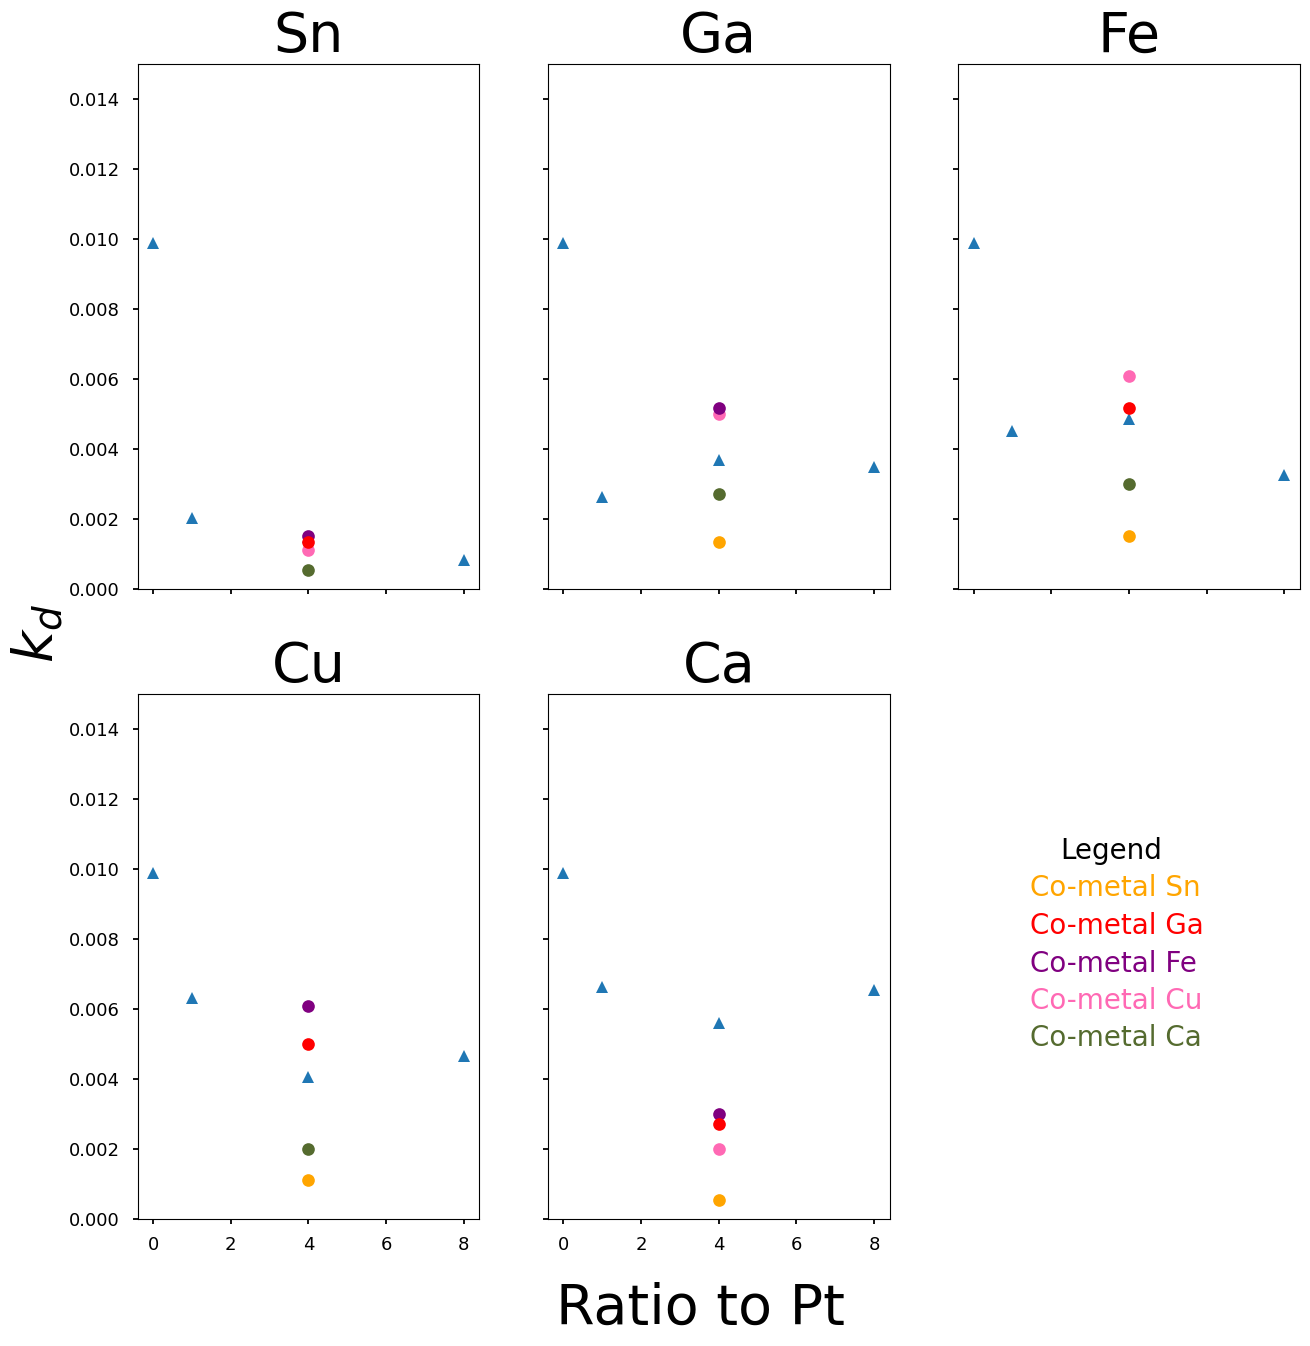

In [99]:
metric = 'k_d'
metals = ['Sn','Ga','Fe','Cu','Ca']
colors = {'Sn':'orange','Ga':'red','Fe':'purple','Cu':'hotpink','Ca':'darkolivegreen'}
nrows = 2
ncols = 3
increment = 0
fig, axs = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        try:
            metal = metals[increment]
            df_subset = get_bimetallics_of_x(df,metal)
            df_subset_trimetallic=get_trimetallics_of_x(df,metal)
            axs[i,j].plot(df_subset[metal],df_subset[metric],marker='^',linestyle='None',label=metal)
            
            for row_idx,row in df_subset_trimetallic.iterrows(): #find co-metal for color label
                co_metal = None
                for potential_co_metal in metals:
                    if potential_co_metal != metal:
                        if row[potential_co_metal] != 0:
                            co_metal = potential_co_metal
                            break
                axs[i,j].plot(df_subset_trimetallic.loc[row_idx,(metal)],df_subset_trimetallic.loc[row_idx,(metric)],'o',color =colors[co_metal] )
            axs[i,j].set_title(metal,fontsize=40)
            axs[i,j].set_ylim([0, 0.015])
        except IndexError:
            a=2
        increment += 1
#Source: https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
fig.text(0.5, 0.04, 'Ratio to Pt',fontsize=40, ha='center')
fig.text(0.04, 0.5,'$k_d$',fontsize=40, va='center', rotation='vertical')
offset=0
fig.text(0.74,0.35-offset,f'Legend',color='black',fontsize=20)
for co_metal in metals:
    offset+=0.025
    fig.text(0.72,0.35-offset,f'Co-metal {co_metal}',color=colors[co_metal],fontsize=20)

#'$\sqrt{Y_0Y_{PC}}$'
# plt.xlabel('Ratio to Pt',fontsize=40)
# plt.ylabel('$\sqrt{Y_0Y_{PC}}$',fontsize=40)

# plt.legend(loc='best')
fig.delaxes(axs[1,2])  # https://stackoverflow.com/questions/28738836/how-to-create-an-odd-number-of-subplots
#fig.tight_layout()
plt.savefig('./manuscript_figures/training-data-feature-plots-with-co-metals-kd.png',dpi=600,bbox_inches="tight")
    
